# Attempt: ABC SMC applied on Lotka Volterra
**Note:**  
This is a purely ABC based file, so does not need the JAX compiled version of PINTS.
> All examples in this notebook are with time space (0,30,50)  
> Contains applications with/without noise using uniform/MVN prior.

## The Lotka Volterra Model

In [68]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

### Example Trajectories

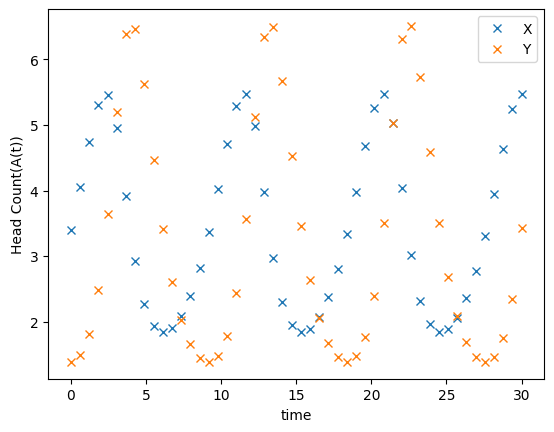

In [99]:
np.random.seed(1)

# Load the LV model
model = toy.LotkaVolterraModel()

# Example of a toy data with suggested parameter values
times = np.linspace(0, 30,50)
params = np.array([0.5,0.15,1,.3])
values = model.simulate(params, times)

plt.plot(times, values[:,0], 'x', label = 'X')
plt.plot(times, values[:,1], 'x', label = 'Y')

plt.legend()
plt.xlabel('time')
plt.ylabel('Head Count(A(t))'),
plt.show()

### Fit ABC SMC  
#### Prior: log uniform prior
Here we use the sum of squares error(SSE) for the distance function to reject/accept.  
Set the thresholds. We accept a parameter value if the $SSE<10$ for the first intermediate distribution, $SSE<7.5$ for the second one and $SSE<5$ for the last.

In [101]:
np.random.seed(8)
problem = pints.MultiOutputProblem(model, times, values)
error_measure = pints.SumOfSquaresError(problem)

log_prior = pints.UniformLogPrior([0,0.1,0,0.25], [1,0.2,2,0.35])
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)

# set threshold schedule
abc.sampler().set_threshold_schedule(np.array([10,7.5,5]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1600)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

/var/folders/3z/d020c1ln2rbdn3rrr_x9nwxh0000gn/T/ipykernel_60914/1860539008.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior([0,0.1,0,0.25], [1,0.2,2,0.35])


Running...
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=10.0
Iter. Eval. Acceptance rate Time m:s
1     614    0.0016286645     0:01.5
2     1211   0.00165152766    0:03.0
3     2917   0.00102845389    0:06.8
20    37470  0.000533760342   1:24.0
40    71881  0.000556475286   2:42.8
60    114408  0.00052443885    4:13.4
80    159653  0.000501086732   5:48.9
100   211939  0.000471833877   7:38.9
120   260405  0.000460820645   9:23.9
140   296180  0.000472685529  10:41.8
160   331629  0.000482466853  11:56.2
180   377017  0.000477432052  13:31.7
Starting t=1, with threshold=7.5
200   426806  0.000468596974  15:19.6
220   427522  0.000514593401  15:21.3
240   428107  0.000560607512  15:22.7
260   429009  0.000606047892  15:24.8
280   429328  0.000652182015  15:25.6
300   430082  0.000697541399  15:27.4
320   430672  0.000743024854  15:28.8
340   431482  0.000787981886  15:30.7
360   432016  0.00083330247   15:32.0
380   433175  0.000877243608  15:34.7
Starting t=2

Can run following code to show first generation examples.
```
plt.hist([x[0] for x in samples[0:150]], label='First generation samples')
plt.xlim(0, 1)
plt.vlines(x=model.suggested_parameters()[0], linestyles='dashed', ymin=0, ymax=30, label='Actual value', color='red')
plt.legend()
plt.show()
```
Similar idea, second generation examples.
```
plt.hist([x[0] for x in samples[150:300]], label='Second generation samples')
plt.xlim(0, 1)
plt.vlines(x=model.suggested_parameters()[0], linestyles='dashed', ymin=0, ymax=30, label='Actual value', color='red')
plt.legend()
plt.show()
```
#### Demonstration

Used first 300 iterations as burn-in period.

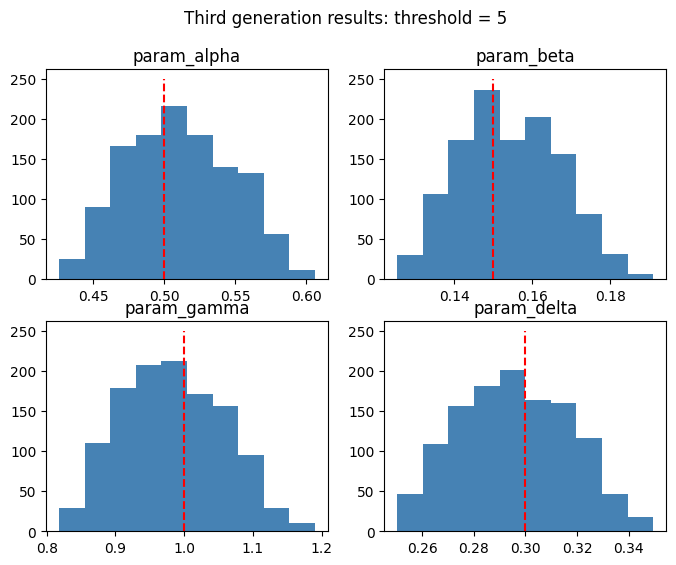

In [102]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0,0].hist([x[0] for x in samples[400:]], color='steelblue')
axs[0,0].set_title('param_alpha')
axs[0,0].vlines(x=model.suggested_parameters()[0], linestyles='dashed', ymin=0, ymax=250, label='Actual value', color='red')

axs[0,1].hist([x[1] for x in samples[400:]], color='steelblue')
axs[0,1].set_title('param_beta')
axs[0,1].vlines(x=model.suggested_parameters()[1], linestyles='dashed', ymin=0, ymax=250, label='Actual value', color='red')

axs[1,0].hist([x[2] for x in samples[400:]], color='steelblue')
axs[1,0].set_title('param_gamma')
axs[1,0].vlines(x=model.suggested_parameters()[2], linestyles='dashed', ymin=0, ymax=250, label='Actual value', color='red')

axs[1,1].hist([x[3] for x in samples[400:]], color='steelblue')
axs[1,1].set_title('param_delta')
axs[1,1].vlines(x=model.suggested_parameters()[3], linestyles='dashed', ymin=0, ymax=250, label='Actual value', color='red')

plt.suptitle('Third generation results: threshold = 5')
plt.show()

#### Prior: MVN prior  
Use another prior here to study the performance of ABC-SMC.  
**Note**: fixed numpy seed = 8

In [103]:
np.random.seed(8)
problem = pints.MultiOutputProblem(model, times, values)
error_measure = pints.SumOfSquaresError(problem)

mean = np.array([0.5,0.15,1,0.3])
var = np.diag([0.05,0.01,0.05,0.01])
log_prior = pints.MultivariateGaussianLogPrior(mean,var)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)

# set threshold schedule
abc.sampler().set_threshold_schedule(np.array([10,7.5,5]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1600)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples_mvn  = abc.run()
print('Done')

Running...
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=10.0


/Users/lthao/miniconda3/envs/prior_cvae/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Iter. Eval. Acceptance rate Time m:s
1     3799   0.000263227165   0:10.1
2     6596   0.000303214069   0:17.9
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8582943282084D+01   r2 =  0.8544170824490D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8582943282084D+01   r2 =  0.8544170824490D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8582943282084D+01   r2 =  0.7074424682627D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anywa

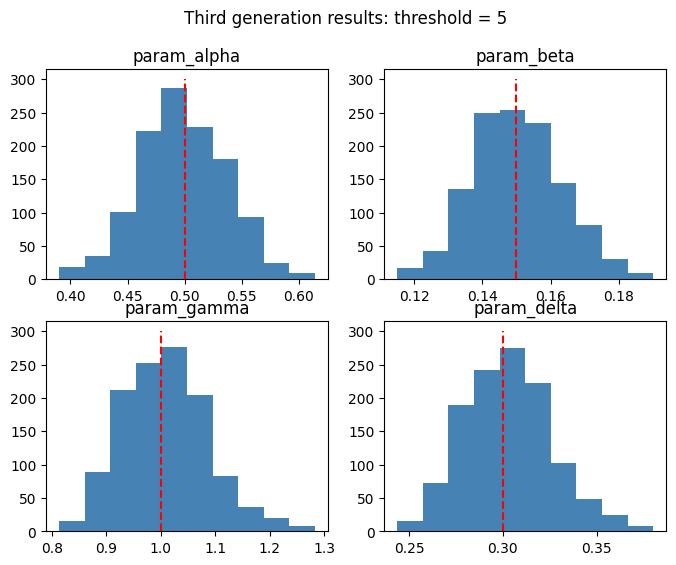

In [105]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0,0].hist([x[0] for x in samples_mvn[400:]], color='steelblue')
axs[0,0].set_title('param_alpha')
axs[0,0].vlines(x=model.suggested_parameters()[0], linestyles='dashed', ymin=0, ymax=300, label='Actual value', color='red')

axs[0,1].hist([x[1] for x in samples_mvn[400:]], color='steelblue')
axs[0,1].set_title('param_beta')
axs[0,1].vlines(x=model.suggested_parameters()[1], linestyles='dashed', ymin=0, ymax=300, label='Actual value', color='red')

axs[1,0].hist([x[2] for x in samples_mvn[400:]], color='steelblue')
axs[1,0].set_title('param_gamma')
axs[1,0].vlines(x=model.suggested_parameters()[2], linestyles='dashed', ymin=0, ymax=300, label='Actual value', color='red')

axs[1,1].hist([x[3] for x in samples_mvn[400:]], color='steelblue')
axs[1,1].set_title('param_delta')
axs[1,1].vlines(x=model.suggested_parameters()[3], linestyles='dashed', ymin=0, ymax=300, label='Actual value', color='red')

plt.suptitle('Third generation results: threshold = 5')
plt.show()

## Lotka Volterra with Noise

### Generate Data with Noise

In [83]:
def add_noise(values,dim,var = 0.1):
    noise = np.random.normal(loc=0,scale=var,size=(dim,2))
    return values + noise

In [96]:
np.random.seed(1)

# Load the LV model
model = toy.LotkaVolterraModel()

# Example of a toy data with suggested parameter values
times = np.linspace(0, 30, 50)
params = np.array([0.5,0.15,1,0.3])
values = model.simulate(params, times)


In [97]:
noisy_values = add_noise(values, dim=50,var=0.2)

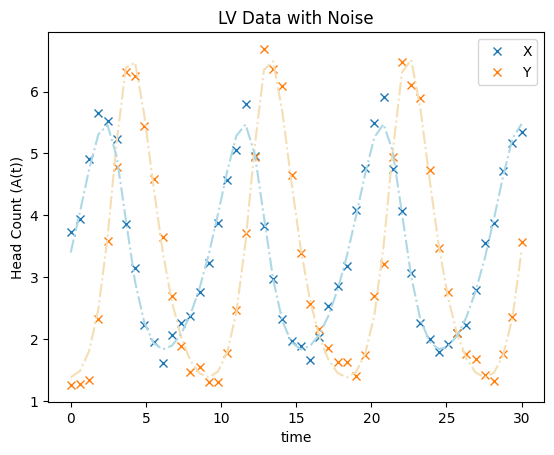

In [98]:
# fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# axs[0].plot(times, values[:,0], 'x', label = 'X1',color='blue')
# axs[0].plot(times, values[:,0], '-.', label = 'X1',color='blue')
# axs[0].plot(times, values[:,1], 'x', label = 'X2',color='g')
# axs[0].plot(times, values[:,1], '-.', label = 'X2',color='g')

# axs[0].set_title('Original Data')
# axs[0].set_xlabel('time')
# axs[0].set_ylabel('concentration (A(t))')

plt.plot(times, noisy_values[:,0], 'x', label = 'X')
plt.plot(times, noisy_values[:,1], 'x', label = 'Y')
plt.plot(times, values[:,1], '-.', color = 'wheat')
plt.plot(times, values[:,0], '-.',color='lightblue')
plt.title('LV Data with Noise')

plt.legend()
plt.xlabel('time')
plt.ylabel('Head Count (A(t))'),
plt.show()

### Fit Using ABC SMC
#### Log uniform prior

In [87]:
np.random.seed(8)
problem = pints.MultiOutputProblem(model, times, noisy_values)
error_measure = pints.SumOfSquaresError(problem)

log_prior = pints.UniformLogPrior([0,0.1,0,0.25], [1,0.2,2,0.35])
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)

# set threshold schedule
abc.sampler().set_threshold_schedule(np.array([10,7.5,5]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1600)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples_noise  = abc.run()
print('Done')

/var/folders/3z/d020c1ln2rbdn3rrr_x9nwxh0000gn/T/ipykernel_60914/4175148186.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior([0,0.1,0,0.25], [1,0.2,2,0.35])


Running...
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=10.0
Iter. Eval. Acceptance rate Time m:s
1     614    0.0016286645     0:01.4
2     12191  0.000164055451   0:25.8
3     12273  0.000244439012   0:26.0
20    94082  0.000212580515   3:21.1
40    152797  0.000261785244   5:29.6
60    233924  0.000256493562   8:23.1
80    277397  0.000288395332   9:55.0
100   363631  0.000275004056  13:10.9
120   436098  0.000275167508  16:07.8
140   498214  0.000281003745  18:38.3
160   633271  0.000252656446  23:42.5
180   702706  0.000256152644  26:15.9
Starting t=1, with threshold=7.5
200   782703  0.000255524765  29:04.9
220   784152  0.000280557851  29:08.3
240   785080  0.00030570133   29:10.4
260   786012  0.000330783754  29:12.6
280   786954  0.000355802245  29:14.9
300   788163  0.000380631925  29:17.7
320   789501  0.000405319309  29:20.9
340   790919  0.000429879672  29:24.4
360   792582  0.000454211678  29:28.4
380   793705  0.0004787673    29:31.3
Starting t=

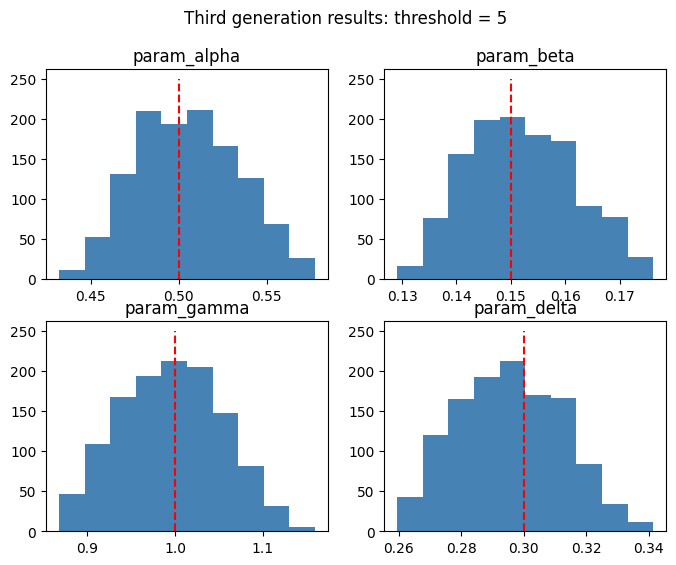

In [106]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0,0].hist([x[0] for x in samples_noise[400:]], color='steelblue')
axs[0,0].set_title('param_alpha')
axs[0,0].vlines(x=model.suggested_parameters()[0], linestyles='dashed', ymin=0, ymax=250, label='Actual value', color='red')

axs[0,1].hist([x[1] for x in samples_noise[400:]], color='steelblue')
axs[0,1].set_title('param_beta')
axs[0,1].vlines(x=model.suggested_parameters()[1], linestyles='dashed', ymin=0, ymax=250, label='Actual value', color='red')

axs[1,0].hist([x[2] for x in samples_noise[400:]], color='steelblue')
axs[1,0].set_title('param_gamma')
axs[1,0].vlines(x=model.suggested_parameters()[2], linestyles='dashed', ymin=0, ymax=250, label='Actual value', color='red')

axs[1,1].hist([x[3] for x in samples_noise[400:]], color='steelblue')
axs[1,1].set_title('param_delta')
axs[1,1].vlines(x=model.suggested_parameters()[3], linestyles='dashed', ymin=0, ymax=250, label='Actual value', color='red')

plt.suptitle('Third generation results: threshold = 5')
plt.show()

#### MVN prior

In [107]:
np.random.seed(8)
problem = pints.MultiOutputProblem(model, times, noisy_values)
error_measure = pints.SumOfSquaresError(problem)

mean = np.array([0.5,0.15,1,0.3])
var = np.diag([0.05,0.01,0.05,0.01])
log_prior = pints.MultivariateGaussianLogPrior(mean,var)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)

# set threshold schedule
abc.sampler().set_threshold_schedule(np.array([10,7.5,5]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1600)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples_noise_mvn  = abc.run()
print('Done')

Running...
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=10.0


/Users/lthao/miniconda3/envs/prior_cvae/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Iter. Eval. Acceptance rate Time m:s
1     3799   0.000263227165   0:11.0
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8582943282084D+01   r2 =  0.8544170824490D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8582943282084D+01   r2 =  0.8544170824490D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8582943282084D+01   r2 =  0.7074424682627D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.85829432

Text(0.5, 0.98, 'Third generation results: threshold = 5')

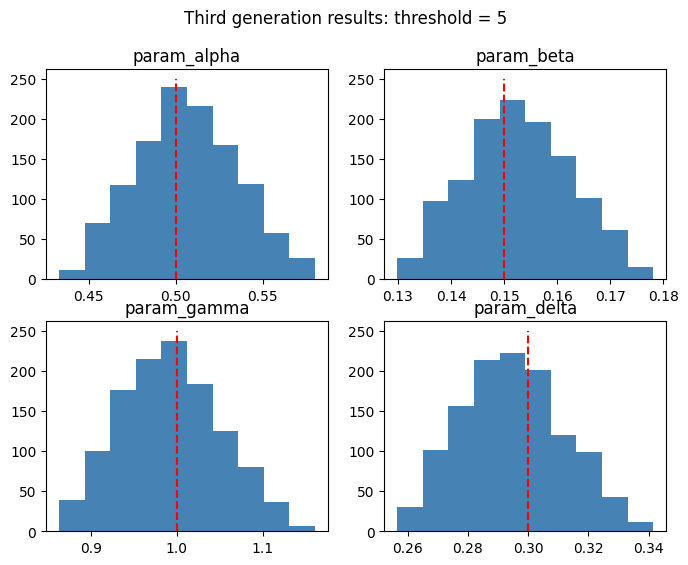

In [108]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0,0].hist([x[0] for x in samples_noise_mvn[400:]], color='steelblue')
axs[0,0].set_title('param_alpha')
axs[0,0].vlines(x=model.suggested_parameters()[0], linestyles='dashed', ymin=0, ymax=250, label='Actual value', color='red')

axs[0,1].hist([x[1] for x in samples_noise_mvn[400:]], color='steelblue')
axs[0,1].set_title('param_beta')
axs[0,1].vlines(x=model.suggested_parameters()[1], linestyles='dashed', ymin=0, ymax=250, label='Actual value', color='red')

axs[1,0].hist([x[2] for x in samples_noise_mvn[400:]], color='steelblue')
axs[1,0].set_title('param_gamma')
axs[1,0].vlines(x=model.suggested_parameters()[2], linestyles='dashed', ymin=0, ymax=250, label='Actual value', color='red')

axs[1,1].hist([x[3] for x in samples_noise_mvn[400:]], color='steelblue')
axs[1,1].set_title('param_delta')
axs[1,1].vlines(x=model.suggested_parameters()[3], linestyles='dashed', ymin=0, ymax=250, label='Actual value', color='red')

plt.suptitle('Third generation results: threshold = 5')

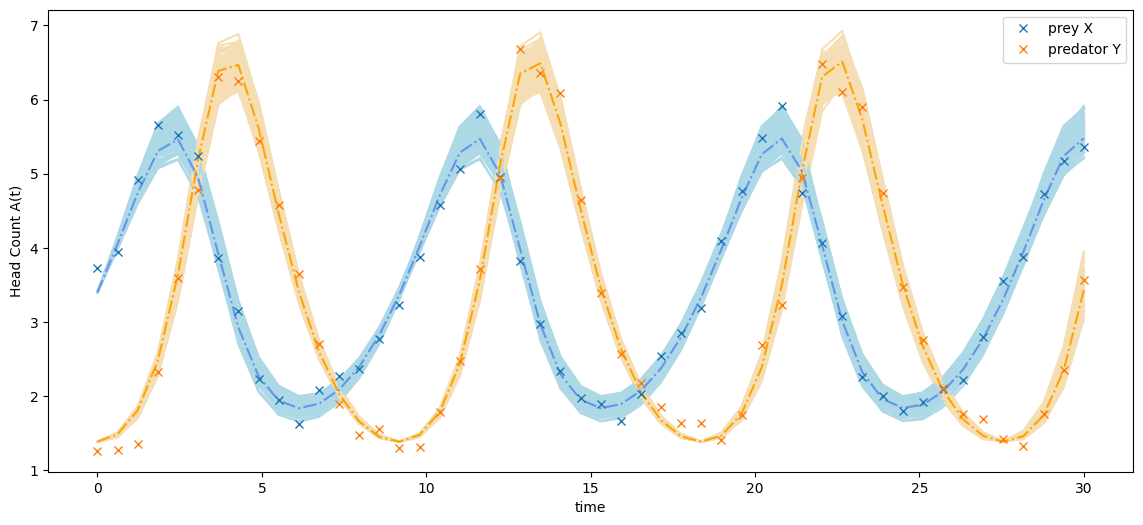

In [118]:
# plot results
plt.figure(figsize=(14,6))


for i in np.random.randint(400, 1600, 100):
    params = samples_noise_mvn[i]
    sim = model.simulate(params, times)
    plt.plot(times, sim[:, 1], color = 'wheat')
    plt.plot(times, sim[:, 0], color='lightblue')
plt.plot(times, values[:,1], '-.', color = 'orange')
plt.plot(times, values[:,0], '-.',color='cornflowerblue')
plt.plot(times, noisy_values[:, 0],'x', label="prey X")
plt.plot(times, noisy_values[:, 1], 'x',label="predator Y")
plt.xlabel("time")
plt.ylabel("Head Count A(t)")
plt.legend()